# Deepfake Detection

### CSEC620 - Project 3

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import keras
from keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LSTM
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

import seaborn as sns
from concurrent.futures import ThreadPoolExecutor
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input

In [ ]:
X_file = 'Dataset/X_data.npy'
Y_file = 'Dataset/Y_data.npy'

# Load X and y
X = np.load(X_file)
y = np.load(Y_file)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## CNN Model
Takes about 2 hours 30 minutes to train.

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Optimizer with adjusted learning rate
optimizer = Adam(learning_rate=0.0001)

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
cnn_model_path = "Models/cnn_model.keras"
if os.path.exists(cnn_model_path):
    print("Loading existing model...")
    model = keras.models.load_model(cnn_model_path)
else:
    print("Training new model...")
    if not os.path.exists("Models"):
        os.mkdir("Models")
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    # Train the model
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping, reduce_lr])
    # Save the model
    model.save(cnn_model_path)

# Evaluate the model
score = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Print test accuracy
print('Test accuracy:', score[1])
# Classification report
print(classification_report(y_test, y_pred_binary))
cm = confusion_matrix(y_test, y_pred_binary)
# ROC AUC score
print('ROC AUC score:', roc_auc_score(y_test, y_pred))

Loading existing model...
121/121 [==============================] - 28s 232ms/step
Test accuracy: 0.9437386393547058
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1965
           1       0.95      0.94      0.94      1892

    accuracy                           0.94      3857
   macro avg       0.94      0.94      0.94      3857
weighted avg       0.94      0.94      0.94      3857

ROC AUC score: 0.9890956430988386


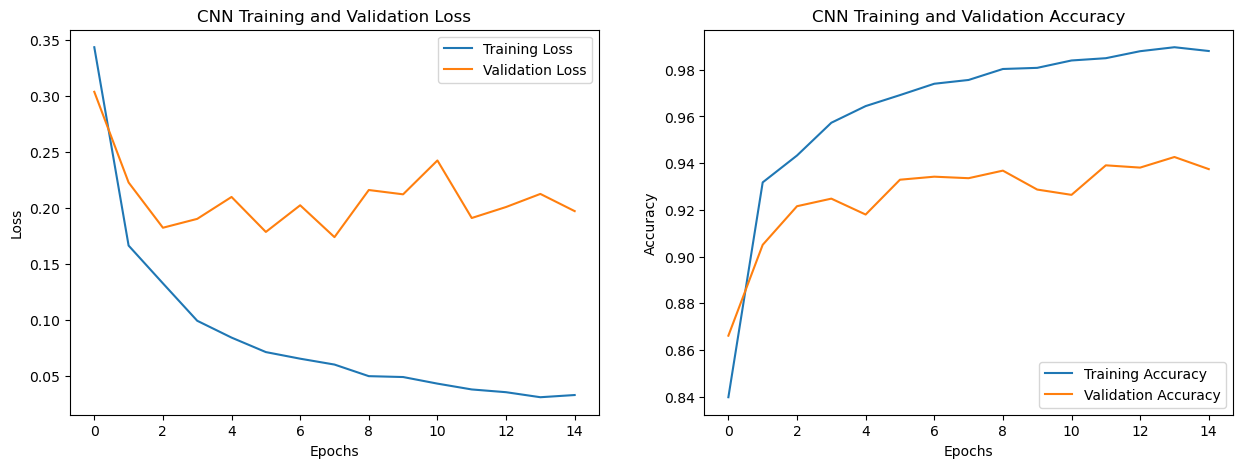

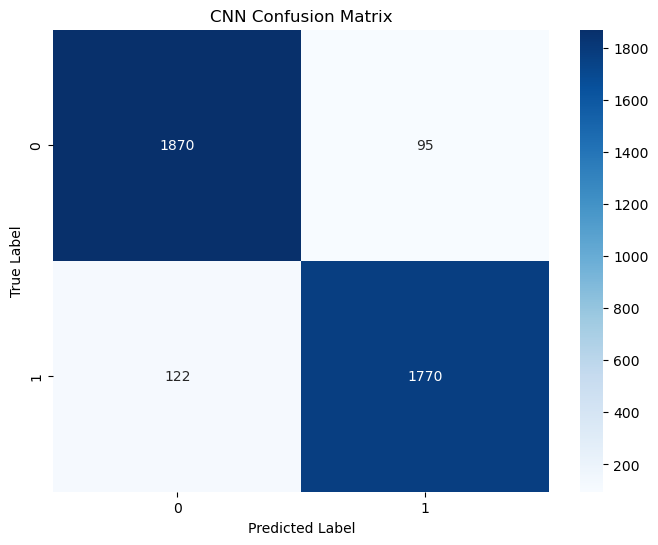

In [ ]:
# Plot the training and validation loss + accuracy along with epochs
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('CNN Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('CNN Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('CNN Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## RNN Model

In [ ]:
# Load pre-trained VGG16 model without the classification layer
VGG_model = VGG16(weights='imagenet', include_top=False)

# Build the model
model = Sequential([
    keras.layers.InputLayer(input_shape=(49, 512)),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Function to extract features from images
def predict_batch(batch):
    return VGG_model.predict(batch)

In [ ]:
rnn_model_path = "Models/rnn_cnn.keras"
features_reshaped_path = 'Dataset/features_reshaped_data.npy'

if os.path.exists(rnn_model_path):
    print("Loading existing model...")
    # Load the model
    model = keras.models.load_model(rnn_model_path)
else:
    print("Training new model...")
    if os.path.exists(features_reshaped_path):
        print("Loading existing features...")
        features_reshaped = np.load(features_reshaped_path)
    else:
        print("Extracting features...")
        # Splitting data into batches
        batch_size = 1000
        batches = [X[i:i + batch_size] for i in range(0, len(X), batch_size)]

        # Using ThreadPoolExecutor for parallel execution
        with ThreadPoolExecutor(max_workers=5) as executor:
            # Extracting features from images
            results = list(executor.map(predict_batch, batches))

        # Combining the results into a single feature array
        features = np.concatenate(results)
        features_reshaped = features.reshape(features.shape[0], 49, 512)
        np.save(features_reshaped_path, features_reshaped)

    # Split the data into training and testing sets
    features_train, features_test, labels_train, labels_test = train_test_split(features_reshaped, y, test_size=0.2, random_state=42)

    # Train the model
    history = model.fit(features_train, labels_train, epochs=15, batch_size=32, validation_split=0.2)
    # Save the model
    model.save(rnn_model_path)

# Evaluate the model
score = model.evaluate(features_test, labels_test)
y_pred = model.predict(features_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Print test accuracy
print('Test accuracy:', score[1])
# Classification report
print(classification_report(labels_test, y_pred_binary))
cm = confusion_matrix(labels_test, y_pred_binary)
# ROC AUC score
print('ROC AUC score:', roc_auc_score(labels_test, y_pred))

Loading existing model...
121/121 [==============================] - 4s 23ms/step
Test accuracy: 0.939590334892273
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1965
           1       0.93      0.95      0.94      1892

    accuracy                           0.94      3857
   macro avg       0.94      0.94      0.94      3857
weighted avg       0.94      0.94      0.94      3857

ROC AUC score: 0.9883263668103008


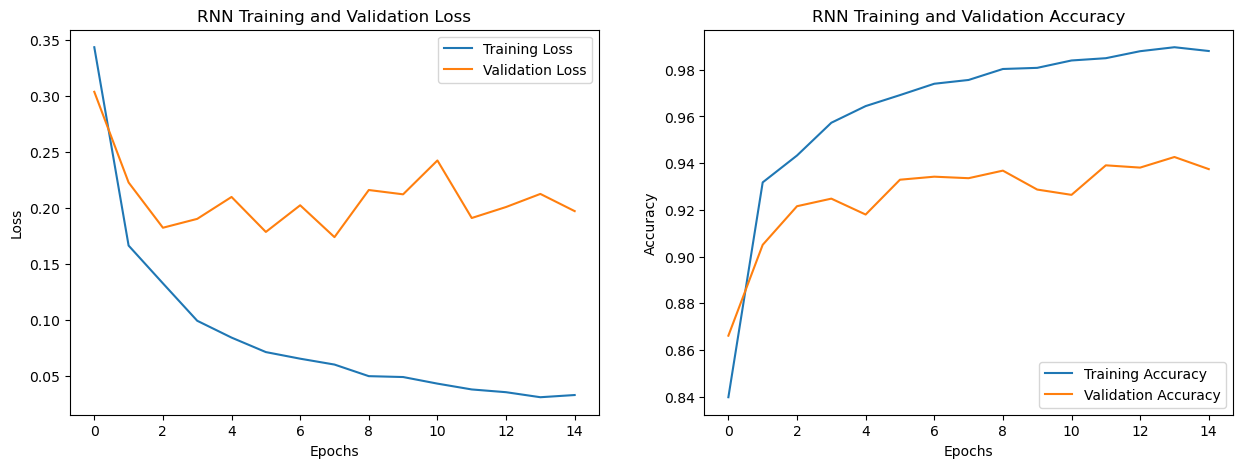

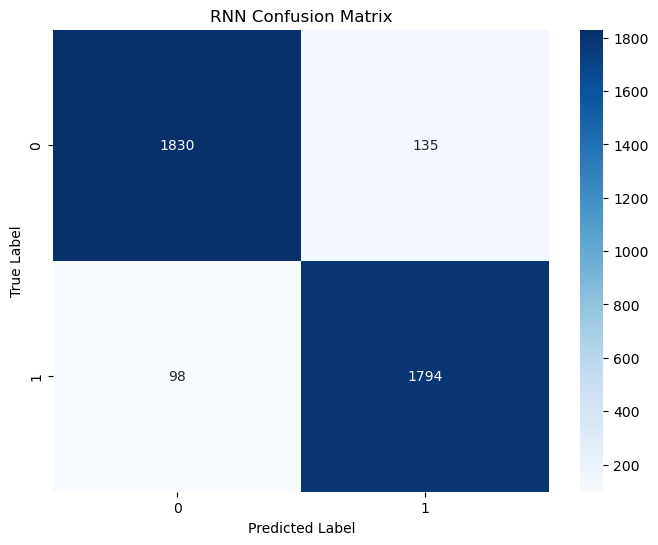

In [ ]:
# Plot the training and validation loss + accuracy along with epochs
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('RNN Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('RNN Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('RNN Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()